C:\Users\ilyaf\AppData\Local\Temp\ipykernel_6764\1891800010.py:37: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  T_full = fsolve(T_full_equation, T_guess, args=(V, k, T_handle))[0]
C:\Users\ilyaf\AppData\Local\Temp\ipykernel_6764\1891800010.py:37: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  T_full = fsolve(T_full_equation, T_guess, args=(V, k, T_handle))[0]


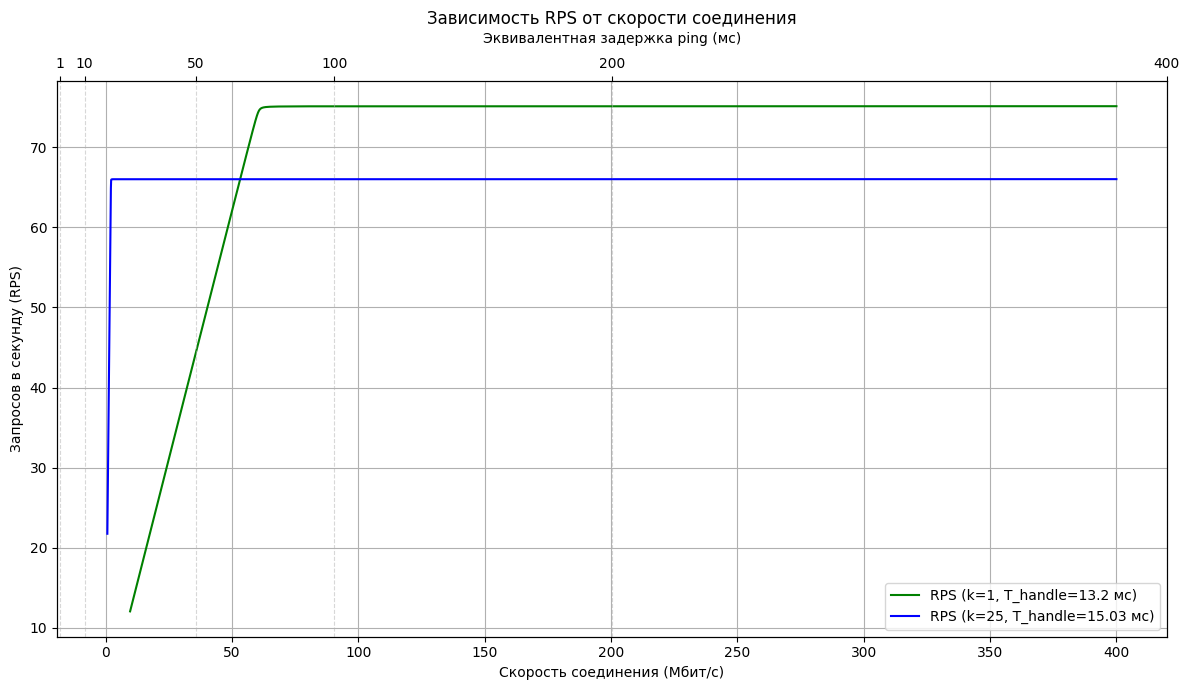

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Заданные параметры
T_ping = 60       # мс
T_wait = 1000     # мс
N = 200
M = 0.8           # мбит

def T_full_equation(T_full, V, k, T_handle):
    alpha_http = (T_handle * N) / T_full
    if alpha_http >= 1:
        return 1e6  # избегаем деления на 0
    
    # Переводим T_full в секунды для вычисления alpha_down
    alpha_down = (M * N) / ((T_full / 1000) * k * V)
    if alpha_down >= 1:
        return 1e6  # избегаем деления на 0
    
    # Все слагаемые должны быть в одинаковых единицах (мс)
    return T_full - (T_ping + T_wait + T_handle / (1 - alpha_http) + (M/(k * V))/(1 - alpha_down) * 1000)

# Диапазон V от 400 до 0.1 с шагом -0.1
V_values = np.arange(400, 0, -0.1)

# Функция для вычисления RPS
def calculate_rps(V_values, k, T_handle):
    T_full_values = []
    initial_guess = T_ping + T_wait + T_handle + N * 1000
    
    for V in V_values:
        try:
            # Начальное приближение
            T_guess = initial_guess + (M/V) * 1000
            
            T_full = fsolve(T_full_equation, T_guess, args=(V, k, T_handle))[0]
            
            alpha_down = (M * N) / ((T_full / 1000) * k * V)
            alpha_http = (T_handle * N) / T_full

            # Проверка корректности решения
            if (0 < alpha_down < 1) and (0 < alpha_http < 1) and (T_full > 0):
                T_full_values.append(T_full)
                initial_guess = T_full  # Обновляем начальное приближение
            else:
                T_full_values.append(np.nan)
        except:
            T_full_values.append(np.nan)
    
    # Фильтрация значений
    valid_indices = ~np.isnan(T_full_values)
    V_values_valid = V_values[valid_indices]
    T_full_valid = np.array(T_full_values)[valid_indices]
    
    # Вычисляем RPS
    if len(T_full_valid) > 0:
        return V_values_valid, (N / T_full_valid) * 1000
    else:
        return np.array([]), np.array([])

# Вычисляем для k=1, T_handle=13.2
V_values1, N_over_T1 = calculate_rps(V_values, k=1, T_handle=13.2)

# Вычисляем для k=25, T_handle=15.03
V_values2, N_over_T2 = calculate_rps(V_values, k=25, T_handle=15.03)

# Построение графиков
plt.figure(figsize=(12, 7))

if len(V_values1) > 0:
    plt.plot(V_values1, N_over_T1, 'g-', label=f'RPS (k=1, T_handle=13.2 мс)')
if len(V_values2) > 0:
    plt.plot(V_values2, N_over_T2, 'b-', label=f'RPS (k=25, T_handle=15.03 мс)')

plt.xlabel('Скорость соединения (Мбит/с)')
plt.ylabel('Запросов в секунду (RPS)')
plt.title('Зависимость RPS от скорости соединения')
plt.grid(True)
plt.legend()

# Добавляем вторую ось X сверху с ping-эквивалентом
ax2 = plt.gca().twiny()
ax2.set_xlim(plt.gca().get_xlim())
ax2.set_xticks([400, 200, 100, 50, 10, 1])
ax2.set_xlabel("Эквивалентная задержка ping (мс)", labelpad=10)
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()